# MegaMart Customer Segmentation Analysis 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [3]:
df = pd.read_csv('retail_customer_data-1.csv')
df.drop('customer_id', axis=1, inplace=True)

In [4]:
print("\n=== First 5 Customers ===")
print(df.head())

print("\n=== Dataset Summary ===")
print(df.describe())


=== First 5 Customers ===
   monthly_transactions  avg_basket_size  total_spend  avg_session_duration  \
0                   1.8              3.0       527.04                  38.1   
1                   5.4              4.5      1137.72                  20.0   
2                   2.9              4.4       670.28                  64.3   
3                  12.0             22.8      6359.35                  37.9   
4                   2.2             17.6      4058.48                  22.5   

   email_open_rate  product_views_per_visit  return_rate  \
0             0.95                     17.3         0.00   
1             0.00                     16.1         0.41   
2             0.52                     36.9         0.11   
3             0.17                     42.2         0.00   
4             0.53                     18.4         0.15   

   customer_tenure_months  recency_days  
0                      23            33  
1                       1             8  
2          

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   monthly_transactions     3000 non-null   float64
 1   avg_basket_size          3000 non-null   float64
 2   total_spend              3000 non-null   float64
 3   avg_session_duration     3000 non-null   float64
 4   email_open_rate          3000 non-null   float64
 5   product_views_per_visit  3000 non-null   float64
 6   return_rate              3000 non-null   float64
 7   customer_tenure_months   3000 non-null   int64  
 8   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 211.1 KB


## Summary

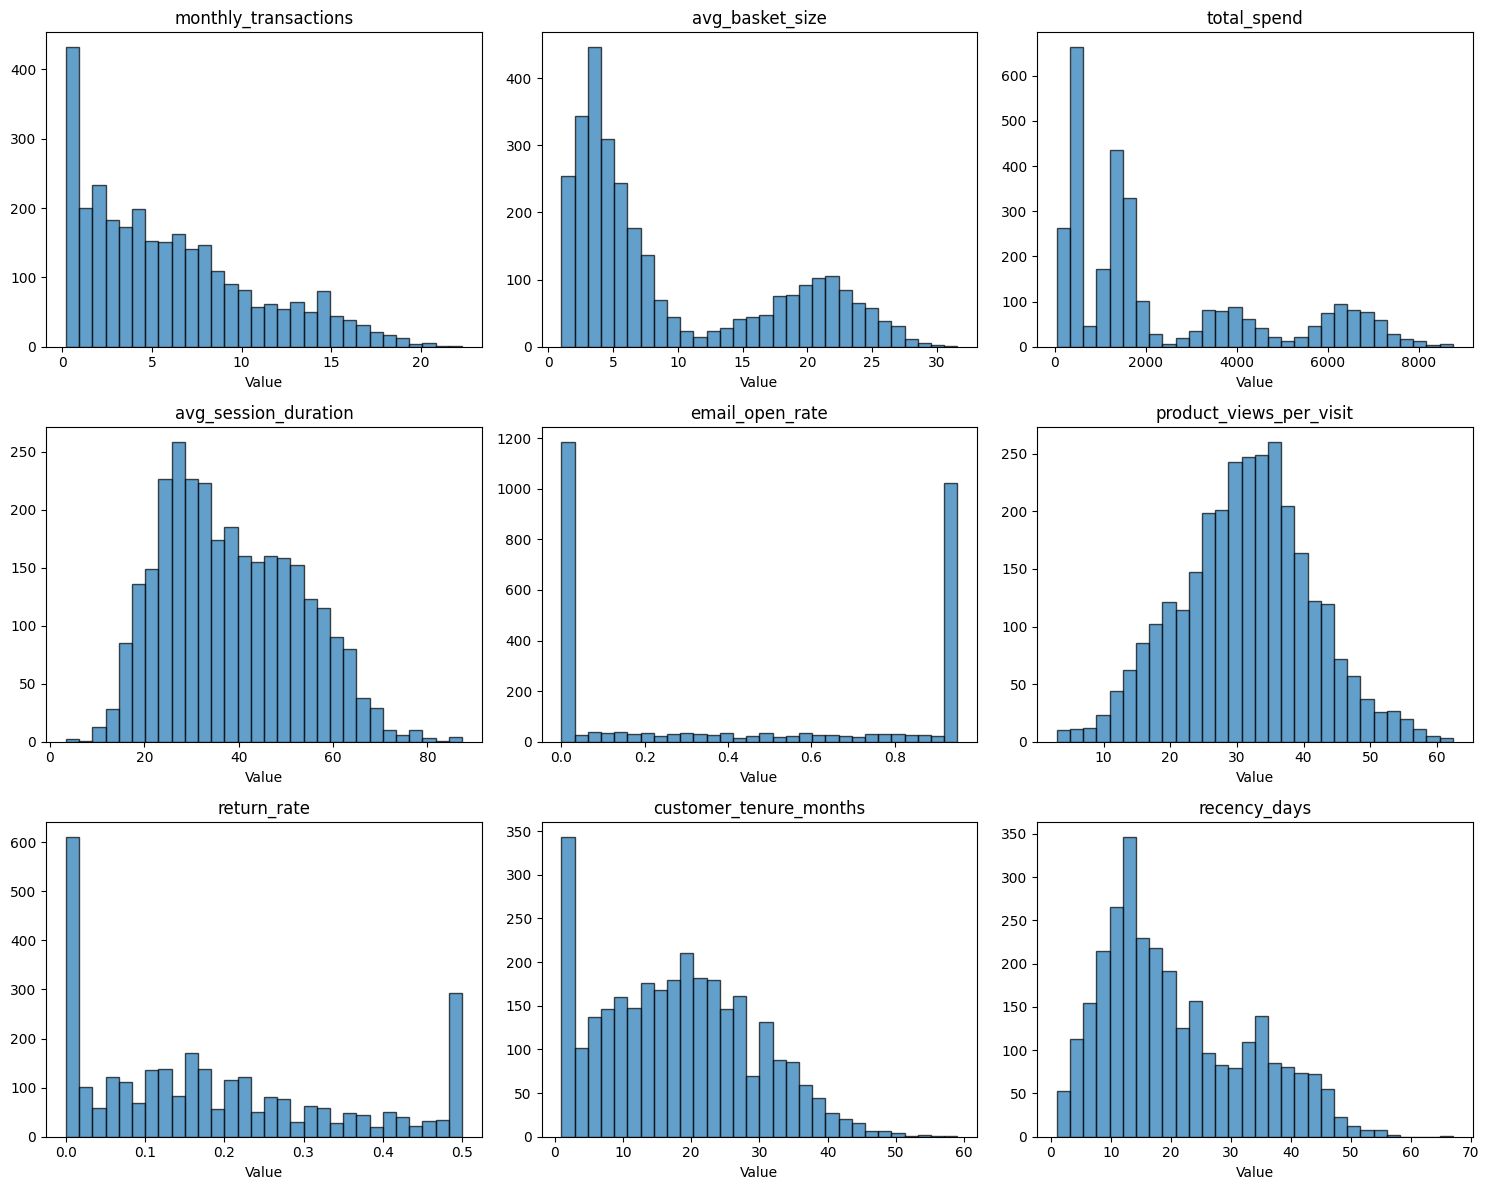

In [6]:
cols_to_plot = df.columns.tolist()
N_cols = len(cols_to_plot)
N_rows = int(np.ceil(N_cols / 3)) 


fig, axes = plt.subplots(N_rows, 3, figsize=(15, 4 * N_rows))


for idx, col in enumerate(cols_to_plot):
    row = idx // 3
    col_idx = idx % 3

    
    if N_rows == 1:
        ax = axes[col_idx]
    else:
        ax = axes[row, col_idx]

    ax.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")

# Optional: Remove any unused subplots if N_cols is not a multiple of 3
for i in range(N_cols, N_rows * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

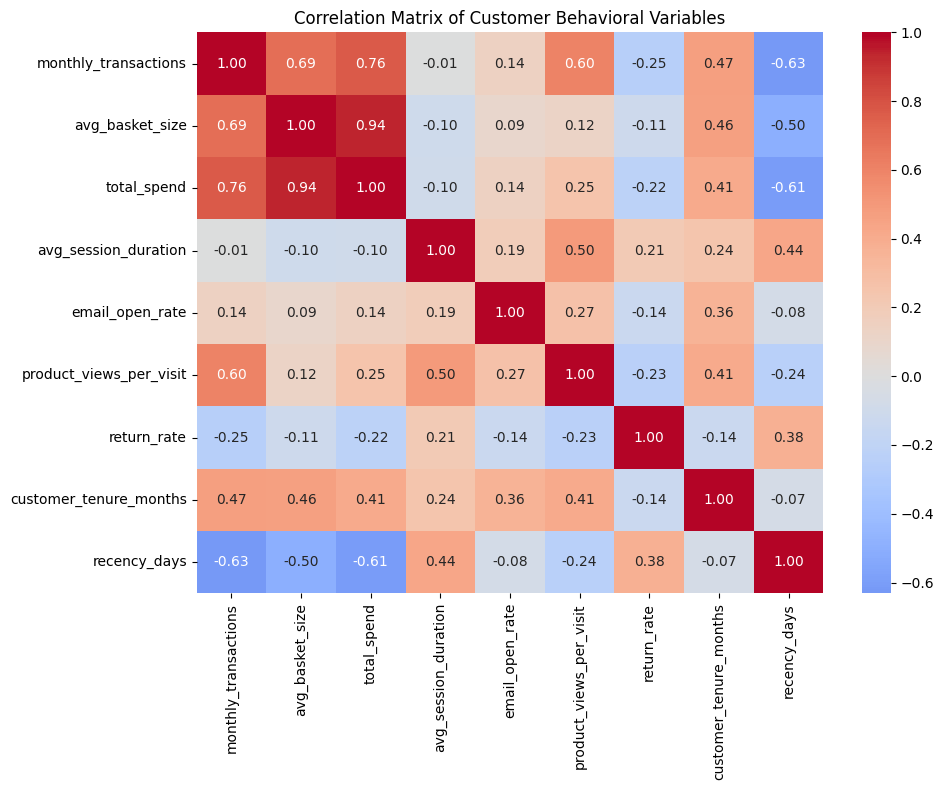


=== Strongest Correlations ===
avg_basket_size <-> total_spend: 0.941
monthly_transactions <-> total_spend: 0.764
monthly_transactions <-> avg_basket_size: 0.691
monthly_transactions <-> recency_days: -0.632
total_spend <-> recency_days: -0.612


In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Customer Behavioral Variables")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Strongest Correlations ===")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            correlation_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs_sorted[:5]:
    print(f"{var1} <-> {var2}: {corr:.3f}")


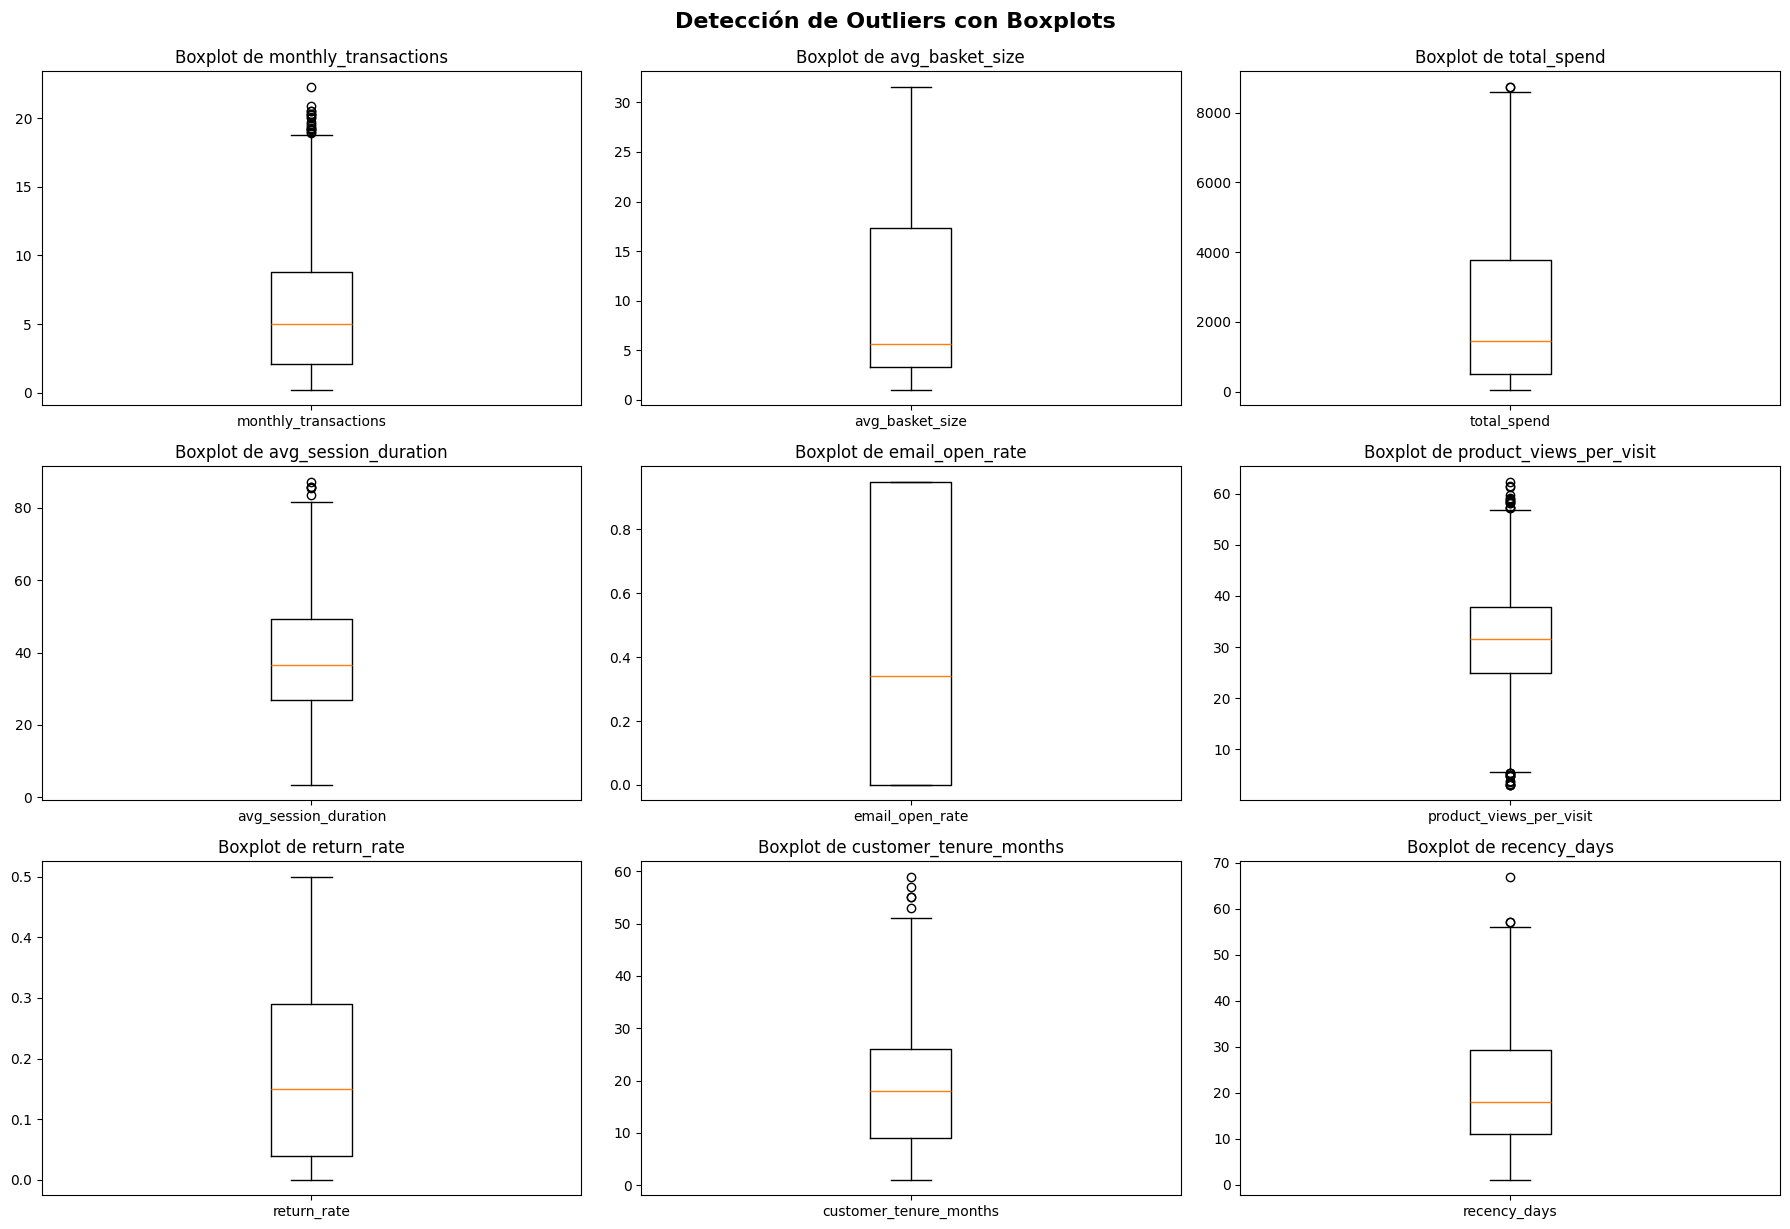

In [8]:
columnas_numericas = df.columns.tolist()
N_cols = len(columnas_numericas)
N_plots_per_row = 3
N_rows = int(np.ceil(N_cols / N_plots_per_row))

fig, axes = plt.subplots(N_rows, N_plots_per_row, figsize=(18, 4 * N_rows))


axes = axes.flatten()


for i, col in enumerate(columnas_numericas):
    axes[i].boxplot(df[col].dropna())
    
    axes[i].set_title(f'Boxplot de {col}', fontsize=12)
    axes[i].set_xticklabels([col]) 
    axes[i].tick_params(axis='y', labelsize=10)

for j in range(N_cols, N_rows * N_plots_per_row):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.suptitle('Detección de Outliers con Boxplots', y=1.02, fontsize=16, fontweight='bold')
plt.show()

Scatter plots saved as 'correlation_scatter_plots.png'


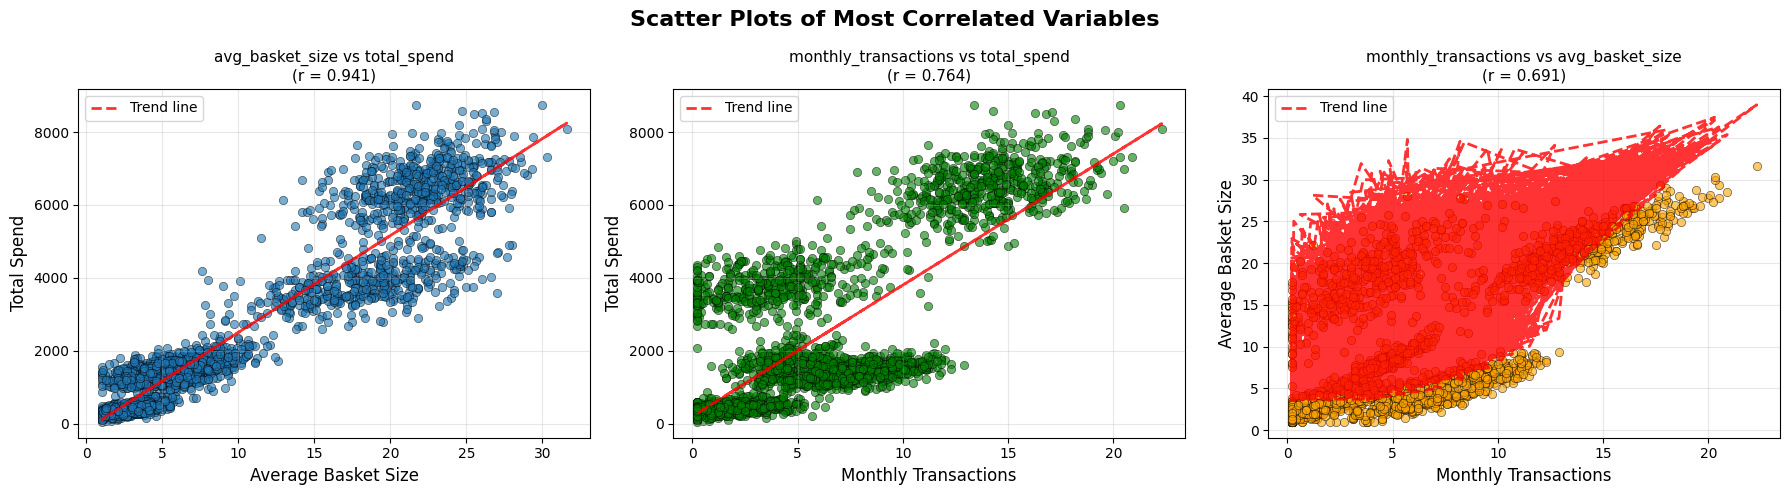

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Scatter Plots of Most Correlated Variables', fontsize=16, fontweight='bold')

axes[0].scatter(df['avg_basket_size'], df['total_spend'], alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel('Average Basket Size', fontsize=12)
axes[0].set_ylabel('Total Spend', fontsize=12)
axes[0].set_title('avg_basket_size vs total_spend\n(r = 0.941)', fontsize=11)
axes[0].grid(True, alpha=0.3)


z = np.polyfit(df['avg_basket_size'], df['total_spend'], 1)
p = np.poly1d(z)
axes[0].plot(df['avg_basket_size'], p(df['avg_basket_size']), 
             "r--", alpha=0.8, linewidth=2, label='Trend line')
axes[0].legend()


axes[1].scatter(df['monthly_transactions'], df['total_spend'], alpha=0.6, 
                edgecolors='k', linewidth=0.5, color='green')
axes[1].set_xlabel('Monthly Transactions', fontsize=12)
axes[1].set_ylabel('Total Spend', fontsize=12)
axes[1].set_title('monthly_transactions vs total_spend\n(r = 0.764)', fontsize=11)
axes[1].grid(True, alpha=0.3)


z = np.polyfit(df['monthly_transactions'], df['total_spend'], 1)
p = np.poly1d(z)
axes[1].plot(df['monthly_transactions'], p(df['monthly_transactions']), 
             "r--", alpha=0.8, linewidth=2, label='Trend line')
axes[1].legend()


axes[2].scatter(df['monthly_transactions'], df['avg_basket_size'], alpha=0.6, 
                edgecolors='k', linewidth=0.5, color='orange')
axes[2].set_xlabel('Monthly Transactions', fontsize=12)
axes[2].set_ylabel('Average Basket Size', fontsize=12)
axes[2].set_title('monthly_transactions vs avg_basket_size\n(r = 0.691)', fontsize=11)
axes[2].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df['monthly_transactions'], df['avg_basket_size'], 1)
p = np.poly1d(z)
axes[2].plot(df['monthly_transactions'], p(df['avg_basket_size']), 
             "r--", alpha=0.8, linewidth=2, label='Trend line')
axes[2].legend()


plt.tight_layout()


plt.savefig('correlation_scatter_plots.png', dpi=300, bbox_inches='tight')
print("Scatter plots saved as 'correlation_scatter_plots.png'")


plt.show()

In [10]:
print("=" * 60)
print("MISSING DATA ANALYSIS")
print("=" * 60)

print("\n1. Missing values count per column:")
print(df.isnull().sum())

MISSING DATA ANALYSIS

1. Missing values count per column:
monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64


In [11]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df)


df_standardized = pd.DataFrame(X_standardized, columns=df.columns)

print("\n=== Standardized Data Summary ===")
print(df_standardized.describe())


=== Standardized Data Summary ===
       monthly_transactions  avg_basket_size   total_spend  \
count          3.000000e+03     3.000000e+03  3.000000e+03   
mean           1.290819e-16    -4.263256e-17  2.842171e-17   
std            1.000167e+00     1.000167e+00  1.000167e+00   
min           -1.216830e+00    -1.065978e+00 -1.030908e+00   
25%           -8.189887e-01    -7.770313e-01 -8.257765e-01   
50%           -2.117565e-01    -4.880849e-01 -4.053880e-01   
75%            5.839270e-01     9.849136e-01  6.249629e-01   
max            3.410697e+00     2.778266e+00  2.837726e+00   

       avg_session_duration  email_open_rate  product_views_per_visit  \
count          3.000000e+03     3.000000e+03             3.000000e+03   
mean           7.460699e-17    -8.526513e-17             4.973799e-17   
std            1.000167e+00     1.000167e+00             1.000167e+00   
min           -2.445025e+00    -1.038395e+00            -2.846642e+00   
25%           -7.983336e-01    -1.038395e

In a Markdown cell, explain why standardization is
necessary for clustering (e.g., "Without standardization, variables with
larger ranges like total_spend would dominate the distance calculations").

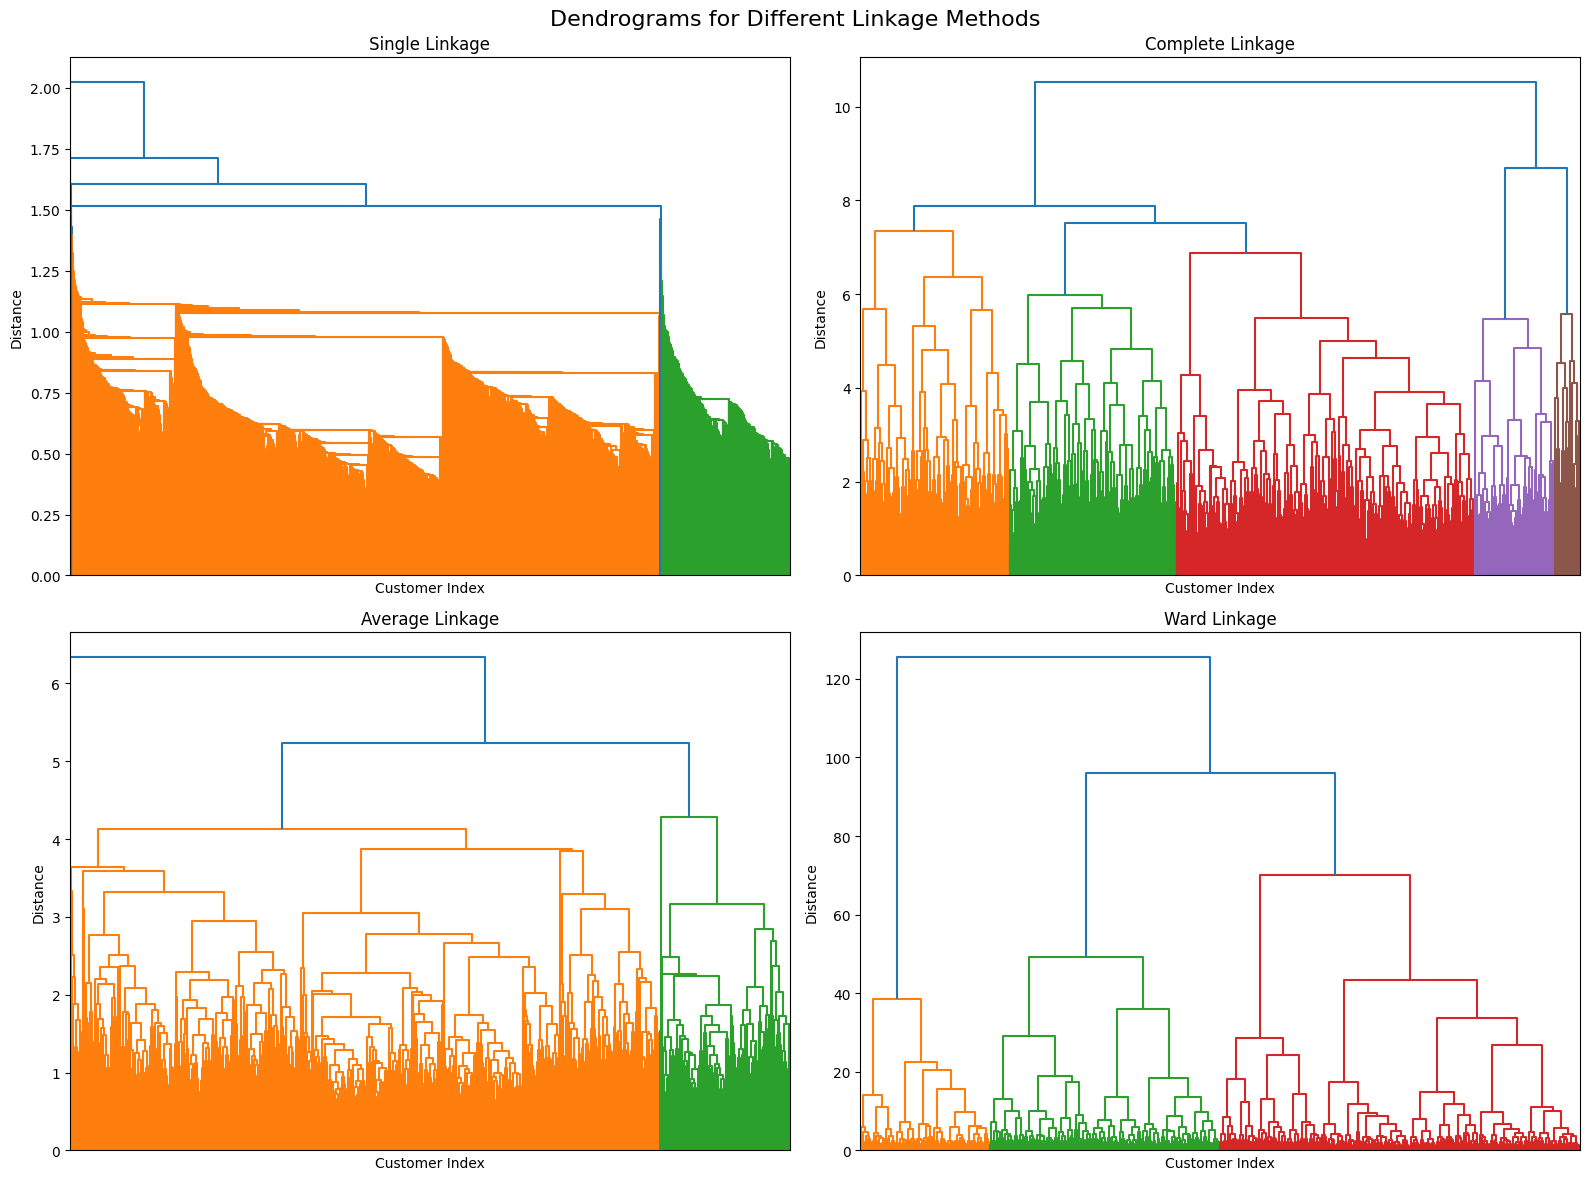


LINKAGE METHOD EXPLANATIONS:
SINGLE: Minimum distance between clusters (nearest neighbor)
COMPLETE: Maximum distance between clusters (farthest neighbor)
AVERAGE: Average distance between all pairs of points
WARD: Minimizes variance within clusters (most commonly used)


In [12]:

# Compute linkage matrices for different methods
linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

for method in linkage_methods:
    linkage_matrices[method] = linkage(X_standardized, method=method)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Dendrograms for Different Linkage Methods", fontsize=16)

for idx, method in enumerate(linkage_methods):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    dendrogram(linkage_matrices[method], ax=ax, no_labels=True)
    ax.set_title(f"{method.capitalize()} Linkage")
    ax.set_xlabel("Customer Index")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.savefig("dendrograms_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("LINKAGE METHOD EXPLANATIONS:")
print("="*60)
print("SINGLE: Minimum distance between clusters (nearest neighbor)")
print("COMPLETE: Maximum distance between clusters (farthest neighbor)")
print("AVERAGE: Average distance between all pairs of points")
print("WARD: Minimizes variance within clusters (most commonly used)")
print("="*60)

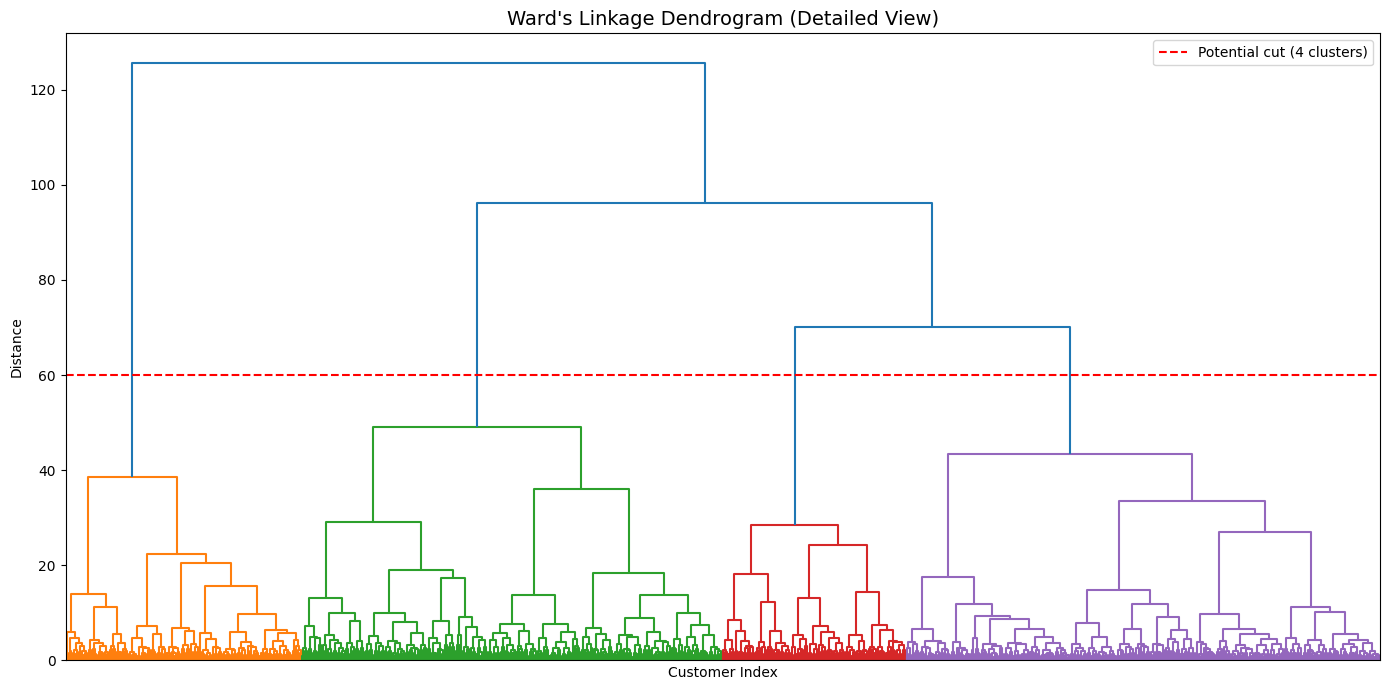


Interpretation: Look for large vertical gaps in the dendrogram.
A horizontal cut at a large gap suggests a natural number of clusters.
The red dashed line shows a potential cut point suggesting 4 clusters.


In [13]:
plt.figure(figsize=(14, 7))
dendrogram(linkage_matrices['ward'], no_labels=True, color_threshold=50)
plt.title("Ward's Linkage Dendrogram (Detailed View)", fontsize=14)
plt.xlabel("Customer Index")
plt.ylabel("Distance")
plt.axhline(y=60, color='r', linestyle='--', label='Potential cut (4 clusters)')
plt.legend()
plt.tight_layout()
plt.savefig("ward_dendrogram_detailed.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation: Look for large vertical gaps in the dendrogram.")
print("A horizontal cut at a large gap suggests a natural number of clusters.")
print("The red dashed line shows a potential cut point suggesting 4 clusters.")

In a Markdown cell, discuss:

1. Which linkage method appears most suitable?

The most suitable linkage method appears to be Ward’s linkage, as it produces well-defined and compact clusters with clear separation between groups. In the dendrogram, you can observe large vertical distances between major merges, which suggests that Ward’s method is effectively minimizing within-cluster variance.

2. Where would you cut the dendrogram? What does the height of merges tell you?

A reasonable cut of the dendrogram is around the point where the tallest vertical jumps occur, which indicates substantial differences between groups being merged. In this case, there appear to be two major branches, and each of them splits naturally into two subgroups, giving a total of four meaningful clusters.

3. hat is the "chaining effect" and which linkage method is most
susceptible to it?

The chaining effect occurs when a clustering method groups points into a single elongated cluster by repeatedly linking points or small groups that are close to each other, even if the resulting cluster has poor overall cohesion. This effect produces long, “chain-like” clusters that do not represent meaningful groups.

The linkage method most susceptible to the chaining effect is Single Linkage, because it merges clusters based solely on the minimum distance between any two points





K = 2 CLUSTERS
  Cluster 0:    540 customers ( 18.0%)
  Cluster 1:   2460 customers ( 82.0%)

Silhouette Score: 0.344
(Range: -1 to +1, higher is better, >0.5 indicates good clustering)

K = 3 CLUSTERS
  Cluster 0:    540 customers ( 18.0%)
  Cluster 1:    959 customers ( 32.0%)
  Cluster 2:   1501 customers ( 50.0%)

Silhouette Score: 0.295
(Range: -1 to +1, higher is better, >0.5 indicates good clustering)

K = 4 CLUSTERS
  Cluster 0:    540 customers ( 18.0%)
  Cluster 1:    959 customers ( 32.0%)
  Cluster 2:    420 customers ( 14.0%)
  Cluster 3:   1081 customers ( 36.0%)

Silhouette Score: 0.316
(Range: -1 to +1, higher is better, >0.5 indicates good clustering)

K = 5 CLUSTERS
  Cluster 0:    540 customers ( 18.0%)
  Cluster 1:    425 customers ( 14.2%)
  Cluster 2:    534 customers ( 17.8%)
  Cluster 3:    420 customers ( 14.0%)
  Cluster 4:   1081 customers ( 36.0%)

Silhouette Score: 0.300
(Range: -1 to +1, higher is better, >0.5 indicates good clustering)

K = 6 CLUSTERS
  

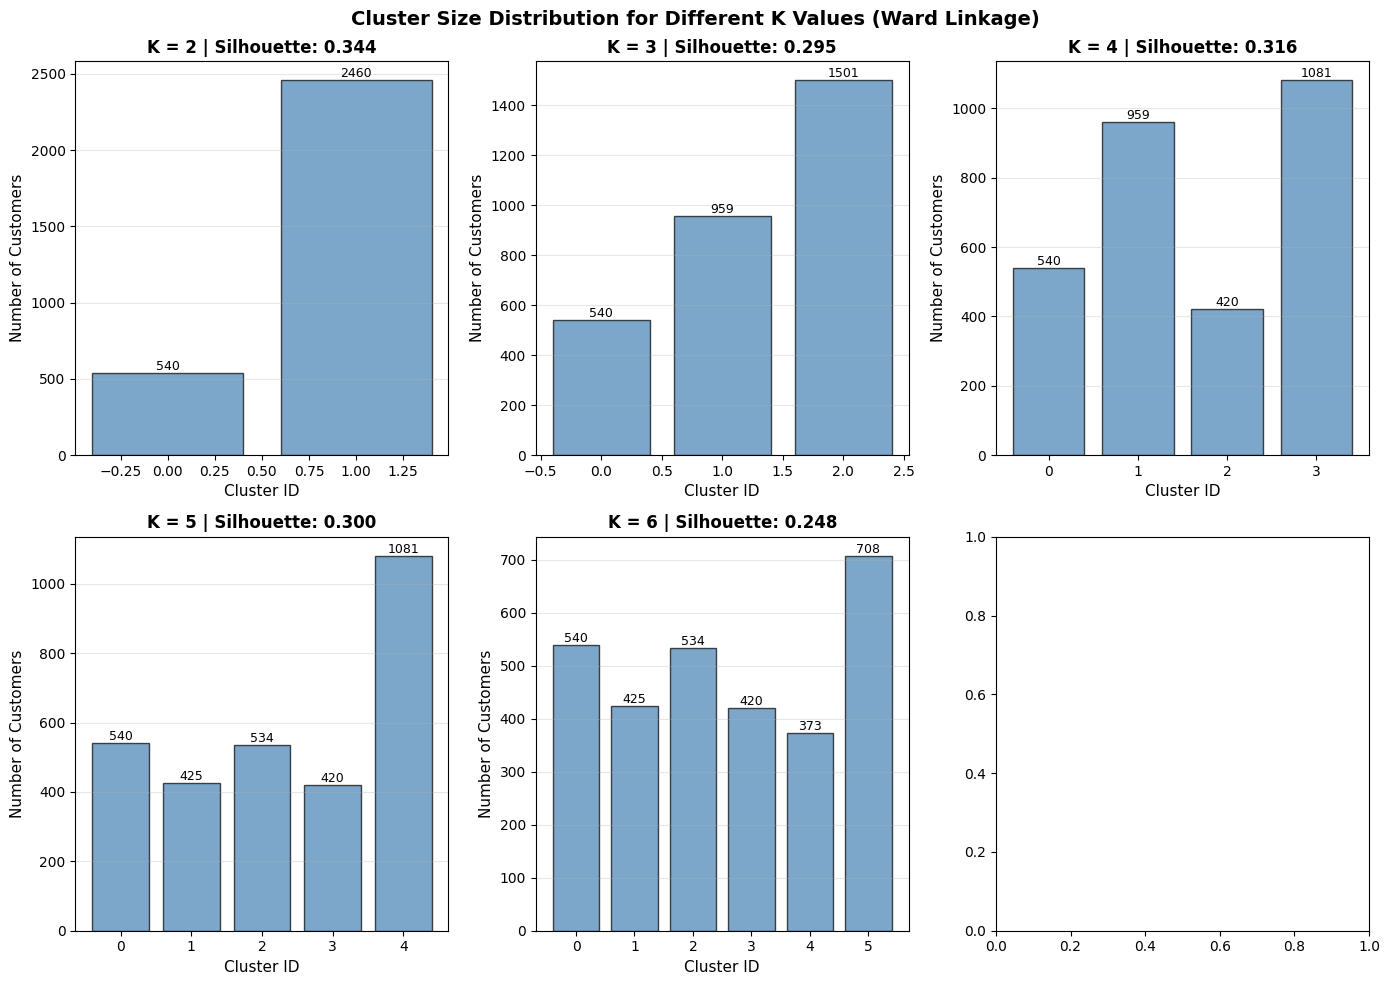

In [14]:
results = {}
all_labels = {}
k_values = [2, 3, 4, 5, 6]

hier_labels_k4 = None
silhouette_hier_k4 = None

for n_clusters_hier in k_values:
    print(f"\n{'='*70}")
    print(f"K = {n_clusters_hier} CLUSTERS")
    print(f"{'='*70}")
    
    # Extract clusters from Ward's linkage
    hierarchical_labels = fcluster(linkage_matrices['ward'], 
                                   n_clusters_hier, 
                                   criterion='maxclust')
    
    # Convert to 0-indexed for consistency
    hierarchical_labels = hierarchical_labels - 1
    
    # Store labels
    all_labels[n_clusters_hier] = hierarchical_labels
    
    unique, counts = np.unique(hierarchical_labels, return_counts=True)
    cluster_info = []
    
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(hierarchical_labels)) * 100
        print(f"  Cluster {cluster_id}: {count:6d} customers ({percentage:5.1f}%)")
        cluster_info.append({
            'cluster': cluster_id,
            'count': count,
            'percentage': percentage
        })
    
    # Calculate silhouette score
    silhouette_hier = silhouette_score(X_standardized, hierarchical_labels)
    print(f"\nSilhouette Score: {silhouette_hier:.3f}")
    print("(Range: -1 to +1, higher is better, >0.5 indicates good clustering)")
    
    if n_clusters_hier == 4:
        hier_labels_k4 = hierarchical_labels.copy()
        silhouette_hier_k4 = silhouette_hier

    # Store results
    results[n_clusters_hier] = {
        'labels': hierarchical_labels,
        'silhouette_score': silhouette_hier,
        'cluster_info': cluster_info,
        'cluster_sizes': dict(zip(unique, counts))
    }

# Visualize cluster sizes for all k values
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle('Cluster Size Distribution for Different K Values (Ward Linkage)', 
             fontsize=14, fontweight='bold')

axes = axes.flatten()

for idx, k in enumerate(k_values):
    cluster_sizes = results[k]['cluster_sizes']
    clusters = list(cluster_sizes.keys())
    sizes = list(cluster_sizes.values())
    
    bars = axes[idx].bar(clusters, sizes, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Cluster ID', fontsize=11)
    axes[idx].set_ylabel('Number of Customers', fontsize=11)
    axes[idx].set_title(f'K = {k} | Silhouette: {results[k]["silhouette_score"]:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(size)}',
                      ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('cluster_extraction_comparison.png', dpi=300, bbox_inches='tight')
print("\nCluster size comparison plot saved as 'cluster_extraction_comparison.png'")
plt.show()



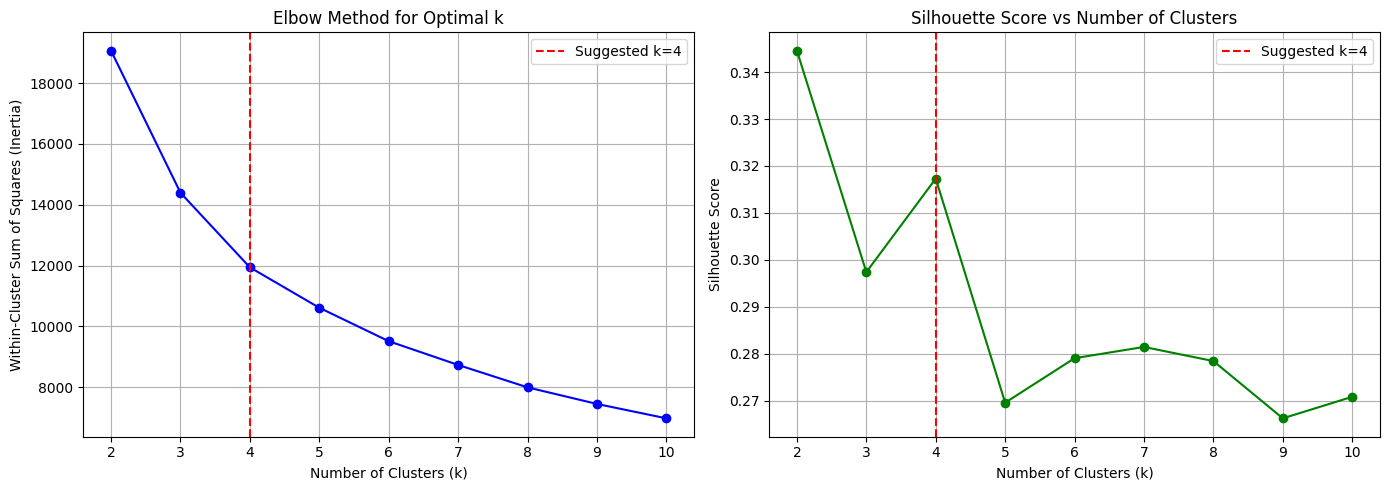

In [15]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_standardized)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_standardized, kmeans.labels_))

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (Inertia)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)
ax1.axvline(x=4, color='r', linestyle='--', label='Suggested k=4')
ax1.legend()

ax2.plot(K_range, silhouette_scores, 'go-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)
ax2.axvline(x=4, color='r', linestyle='--', label='Suggested k=4')
ax2.legend()

plt.tight_layout()
plt.savefig("elbow_silhouette_analysis.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
print(f"\n{'K':<5} {'Silhouette Score':<20} {'Min Size':<12} {'Max Size':<12} {'Std Size':<12}")
print("-"*70)
for k in k_values:
    sil_score = results[k]['silhouette_score']
    sizes = list(results[k]['cluster_sizes'].values())
    min_size = min(sizes)
    max_size = max(sizes)
    std_size = np.std(sizes)
    
    print(f"{k:<5} {sil_score:<20.3f} {min_size:<12d} {max_size:<12d} {std_size:<12.1f}")

# Find best k based on silhouette score
best_k = max(results.keys(), key=lambda k: results[k]['silhouette_score'])
print(f"\nBest k based on Silhouette Score: {best_k} (Score: {results[best_k]['silhouette_score']:.3f})")




SUMMARY COMPARISON

K     Silhouette Score     Min Size     Max Size     Std Size    
----------------------------------------------------------------------
2     0.344                540          2460         960.0       
3     0.295                540          1501         393.4       
4     0.316                420          1081         276.7       
5     0.300                420          1081         245.9       
6     0.248                373          708          111.2       

Best k based on Silhouette Score: 2 (Score: 0.344)


In a Markdown cell, identify where the "elbow" occurs.
Does the silhouette score agree?

Write a clear explanation citing:

- Dendrogram structure (large vertical gaps)
- Elbow plot inflection point
- Silhouette scores
- Business considerations (too few clusters = overgeneralization,
too many = not actionable)

The silhouette value indicates that the data has a clear structure of two clusters.
However, analysis of the elbow and the second silhouette peak suggests that segmentation into four clusters captures relevant substructures.
Depending on the desired level of granularity, k = 2 or k = 4 are valid options. In this case, we want to identify those more specific segments or subgroups, so we choose k = 4.

In [17]:
# Apply k-means with optimal k
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_standardized)


print("\n=== K-Means Clustering Results ===")
print(f"Number of clusters: {optimal_k}")
print("\nCluster sizes:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(kmeans_labels)) * 100
    print(f"  Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")

# Calculate silhouette score
silhouette_kmeans = silhouette_score(X_standardized, kmeans_labels)
print(f"\nSilhouette Score: {silhouette_kmeans:.3f}")

print("\n=== Comparison with Hierarchical Clustering ===")
print(f"Hierarchical (Ward) silhouette: {silhouette_hier_k4:.3f}")
print(f"K-means silhouette: {silhouette_kmeans:.3f}")


=== K-Means Clustering Results ===
Number of clusters: 4

Cluster sizes:
  Cluster 0: 525 customers (17.5%)
  Cluster 1: 929 customers (31.0%)
  Cluster 2: 433 customers (14.4%)
  Cluster 3: 1113 customers (37.1%)

Silhouette Score: 0.317

=== Comparison with Hierarchical Clustering ===
Hierarchical (Ward) silhouette: 0.316
K-means silhouette: 0.317



=== K-Means Cluster Profiles (Mean Values) ===
                monthly_transactions  avg_basket_size  total_spend  \
Cluster_KMeans                                                       
0                              14.07            22.03      6507.29   
1                               1.68             3.05       422.62   
2                               4.04            18.17      3875.94   
3                               6.59             5.56      1450.95   

                avg_session_duration  email_open_rate  \
Cluster_KMeans                                          
0                              45.92             0.58   
1                              52.31             0.37   
2                              22.36             0.45   
3                              29.60             0.44   

                product_views_per_visit  return_rate  customer_tenure_months  \
Cluster_KMeans                                                                 
0                           

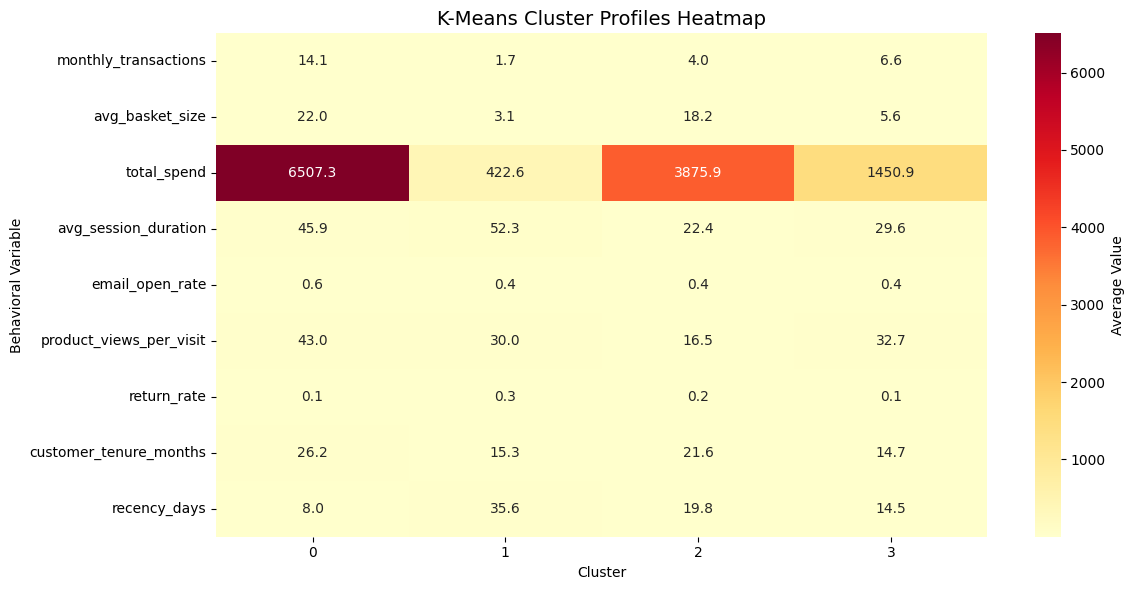

In [18]:
# Add cluster labels to original data
df_with_clusters = df.copy()
df_with_clusters['Cluster_KMeans'] = kmeans_labels
df_with_clusters['Cluster_Hierarchical'] = hier_labels_k4

# Calculate cluster means (in original units)
cluster_profiles = df_with_clusters.groupby('Cluster_KMeans')[df.columns].mean()

print("\n=== K-Means Cluster Profiles (Mean Values) ===")
print(cluster_profiles.round(2))

# Create heatmap of cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
plt.title('K-Means Cluster Profiles Heatmap', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Behavioral Variable')
plt.tight_layout()
plt.savefig("cluster_profiles_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


=== K-Means Cluster Profiles (Mean Values) ===
                monthly_transactions  avg_basket_size  avg_session_duration  \
Cluster_KMeans                                                                
0                              14.07            22.03                 45.92   
1                               1.68             3.05                 52.31   
2                               4.04            18.17                 22.36   
3                               6.59             5.56                 29.60   

                email_open_rate  product_views_per_visit  return_rate  \
Cluster_KMeans                                                          
0                          0.58                    43.01         0.10   
1                          0.37                    30.01         0.27   
2                          0.45                    16.55         0.24   
3                          0.44                    32.75         0.13   

                customer_tenure_months

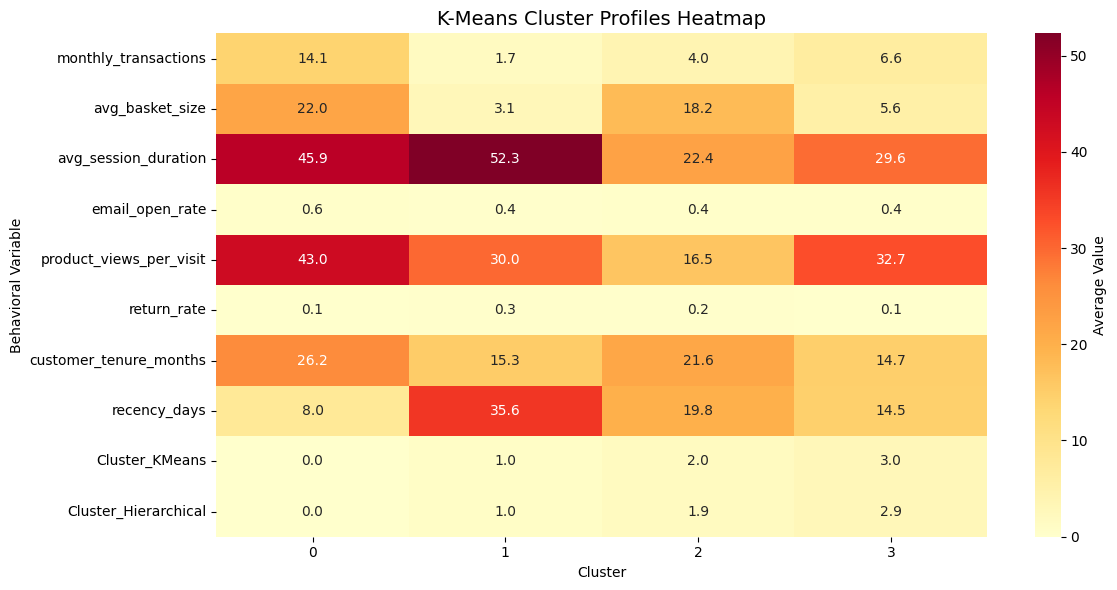

In [19]:
# Add cluster labels to original data
df_with_clusters = df.drop('total_spend', axis=1)
df_with_clusters['Cluster_KMeans'] = kmeans_labels
df_with_clusters['Cluster_Hierarchical'] = hier_labels_k4

# Calculate cluster means (in original units)
cluster_profiles = df_with_clusters.groupby('Cluster_KMeans')[df_with_clusters.columns].mean()

print("\n=== K-Means Cluster Profiles (Mean Values) ===")
print(cluster_profiles.round(2))

# Create heatmap of cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
plt.title('K-Means Cluster Profiles Heatmap', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Behavioral Variable')
plt.tight_layout()
plt.savefig("cluster_profiles_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
overall_means = df.mean()

print("\n=== Cluster Characterization (Comparison to Overall Means) ===")
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id} (n={counts[cluster_id]}, {(counts[cluster_id]/len(df)*100):.1f}%):")
    cluster_mean = cluster_profiles.loc[cluster_id]
    
    # Find features significantly above or below average
    differences = ((cluster_mean - overall_means) / overall_means * 100)
    
    # Show top distinguishing features
    high_features = differences.nlargest(3)
    low_features = differences.nsmallest(3)
    
    print("  Distinctive High Features:")
    for feat, diff in high_features.items():
        if diff > 10:
            print(f"    - {feat}: {diff:+.1f}% vs average")
    
    print("  Distinctive Low Features:")
    for feat, diff in low_features.items():
        if diff < -10:
            print(f"    - {feat}: {diff:+.1f}% vs average")


=== Cluster Characterization (Comparison to Overall Means) ===

Cluster 0 (n=525, 17.5%):
  Distinctive High Features:
    - monthly_transactions: +134.1% vs average
    - avg_basket_size: +132.2% vs average
    - customer_tenure_months: +46.4% vs average
  Distinctive Low Features:
    - recency_days: -61.2% vs average
    - return_rate: -46.7% vs average

Cluster 1 (n=929, 31.0%):
  Distinctive High Features:
    - recency_days: +72.1% vs average
    - return_rate: +47.8% vs average
    - avg_session_duration: +36.1% vs average
  Distinctive Low Features:
    - monthly_transactions: -72.0% vs average
    - avg_basket_size: -67.8% vs average
    - email_open_rate: -15.7% vs average

Cluster 2 (n=433, 14.4%):
  Distinctive High Features:
    - avg_basket_size: +91.6% vs average
    - return_rate: +31.7% vs average
    - customer_tenure_months: +20.6% vs average
  Distinctive Low Features:
    - product_views_per_visit: -47.2% vs average
    - avg_session_duration: -41.8% vs average
  

For each cluster, write a 2-3 sentence profile identifying
its distinctive characteristics:

Cluster 0 --- High-Value Champions

- Highly profitable customers with high purchase frequency, large basket sizes, low recency, and long tenure.  

Cluster 1 --- Window Shoppers

- Users who browse frequently but rarely convert, exhibit high recency, and show elevated return rates.

Cluster 2 --- Premium Occasional Buyers

- Customers who make few but high-value purchases; short sessions with minimal browsing. 

Cluster 3 --- Low-Engagement Mass Segment

- The largest but least profitable segment: low ticket size, low interaction, and limited contribution to revenue.

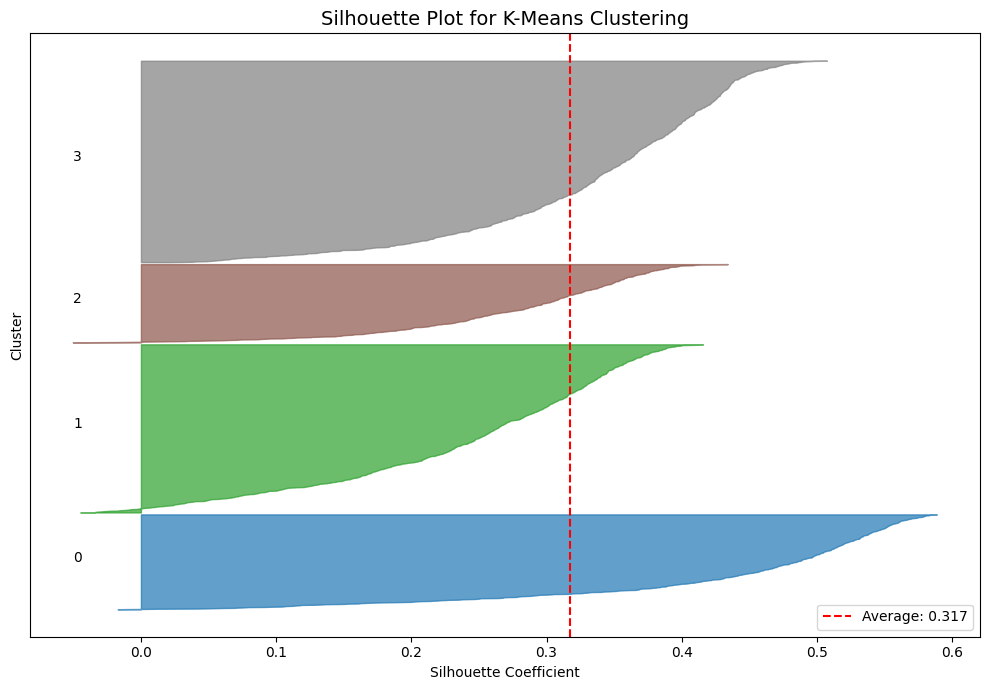


Interpretation:
- Width of silhouette plot = cluster size
- Silhouette coefficient close to +1: well-matched to own cluster
- Silhouette coefficient close to 0: on border between clusters
- Silhouette coefficient close to -1: possibly assigned to wrong cluster
- Red dashed line shows average silhouette score across all customers


In [21]:
# Calculate silhouette values for each sample
silhouette_vals = silhouette_samples(X_standardized, kmeans_labels)

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette values for cluster i
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot for K-Means Clustering', fontsize=14)
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.axvline(x=silhouette_kmeans, color="red", linestyle="--", label=f'Average: {silhouette_kmeans:.3f}')
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.savefig("silhouette_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Width of silhouette plot = cluster size")
print("- Silhouette coefficient close to +1: well-matched to own cluster")
print("- Silhouette coefficient close to 0: on border between clusters")
print("- Silhouette coefficient close to -1: possibly assigned to wrong cluster")
print("- Red dashed line shows average silhouette score across all customers")

Which clusters are well-defined (high silhouette values)?
Are there any customers poorly matched to their cluster (negative
silhouette)?
Does this validate your choice of k?

The silhouette plot by cluster shows that several points have values close to 0, indicating less defined boundaries between segments. However, clusters 0 and 3 contain the highest values, close to 1, suggesting that they are the best-structured groups. Although cluster 3 includes some values close to 0, it also exhibits a longer distribution of positive silhouettes compared to the other clusters, reinforcing its internal consistency. Overall, the presence of very few negative values indicates that most observations are well assigned and that there is a reasonably stable cluster structure within the dataset. Therefore, the data validates our choice of k.

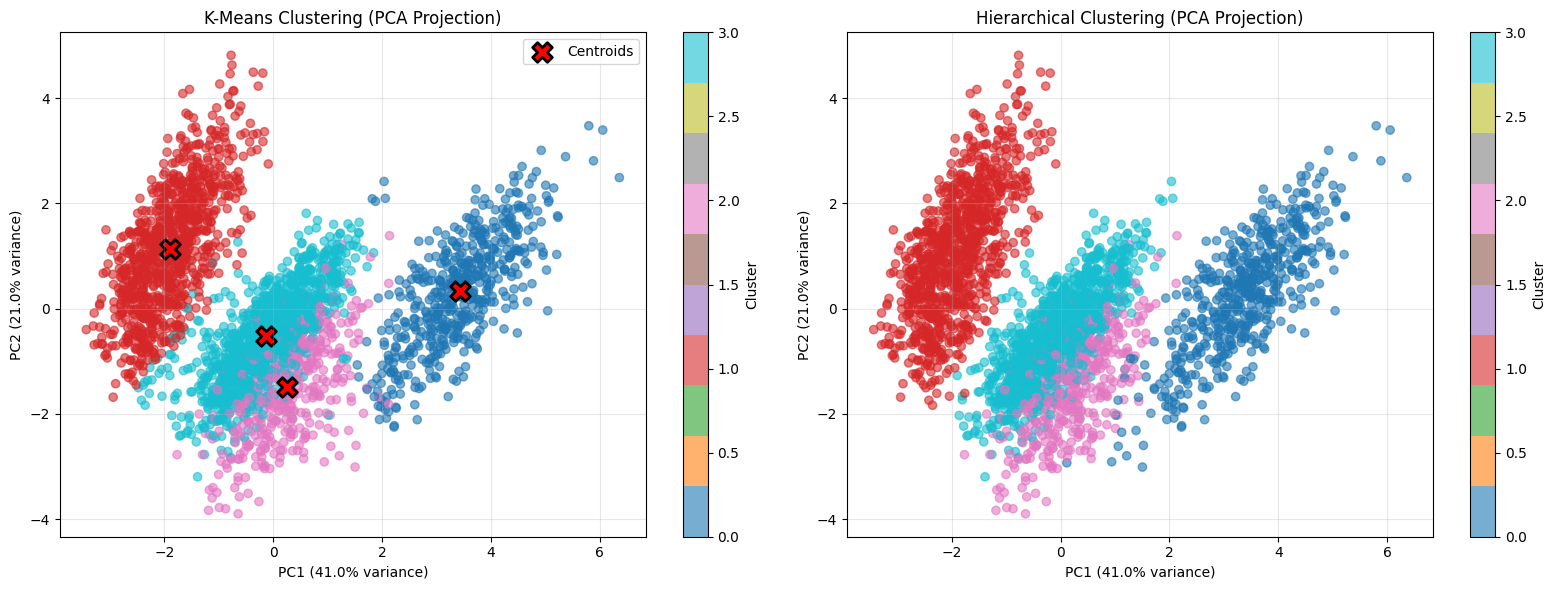


Note: This 2D projection captures 62.0% of total variance.
The actual clusters exist in 9-dimensional space and may be more separated than shown here.


In [22]:
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Create scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means clusters
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6)
ax1.scatter(pca.transform(kmeans_final.cluster_centers_)[:, 0], 
           pca.transform(kmeans_final.cluster_centers_)[:, 1],
           marker='X', s=200, c='red', edgecolors='black', linewidths=2, label='Centroids')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('K-Means Clustering (PCA Projection)')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Hierarchical clusters
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels_k4, cmap='tab10', alpha=0.6)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.set_title('Hierarchical Clustering (PCA Projection)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.savefig("cluster_visualization_pca.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nNote: This 2D projection captures {pca.explained_variance_ratio_.sum():.1%} of total variance.")
print("The actual clusters exist in 9-dimensional space and may be more separated than shown here.")

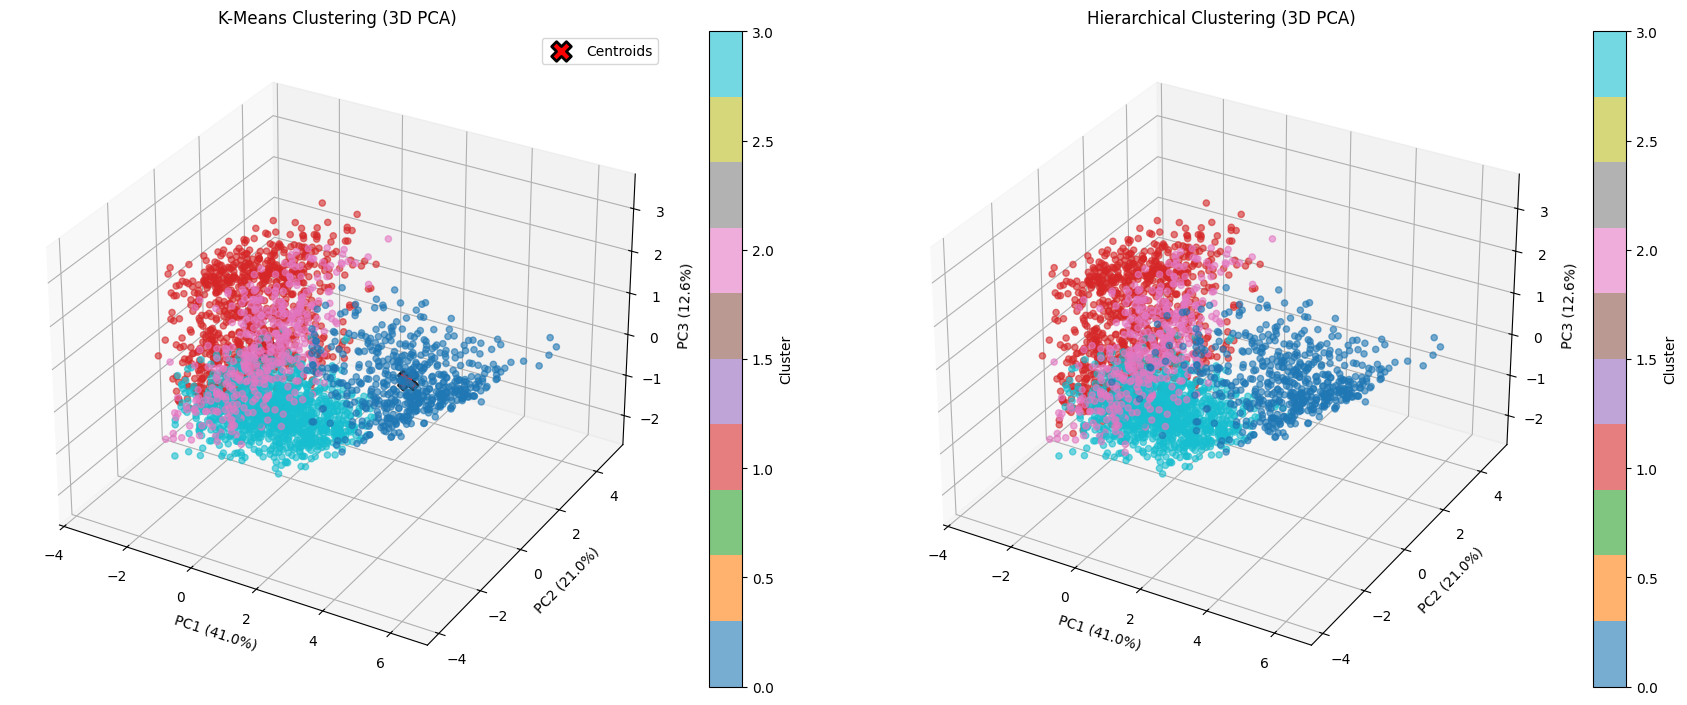


Este PCA 3D captura 74.6% de la varianza total.


In [23]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Apply PCA to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Create 3D scatter plots
fig = plt.figure(figsize=(18, 7))

# -----------------------------
# 3D Plot - K-Means
# -----------------------------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=kmeans_labels, cmap='tab10', alpha=0.6
)

# Centroids projected into PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax1.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
    marker='X', s=200, c='red', edgecolors='black', linewidths=2, label='Centroids'
)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
ax1.set_title("K-Means Clustering (3D PCA)")
ax1.legend()
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# -----------------------------
# 3D Plot - Hierarchical Clustering
# -----------------------------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=hier_labels_k4, cmap='tab10', alpha=0.6
)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
ax2.set_title("Hierarchical Clustering (3D PCA)")
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.savefig("cluster_visualization_pca_3d.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEste PCA 3D captura {pca.explained_variance_ratio_.sum():.1%} de la varianza total.")


Summarize your technical findings:

- Optimal number of clusters and justification
- Hierarchical vs K-means comparison
- Quality metrics (silhouette scores)
- Key characteristics of each discovered segment

The silhouette analysis shows that the dataset has a well-defined underlying structure with a strong peak at k = 2, indicating that two clusters provide the cleanest separation. However, the elbow method and a secondary silhouette peak at k = 4 reveal additional internal groupings that become visible with a more granular segmentation. Since the objective of this analysis is to uncover more detailed subgroups rather than only the broadest division, the segmentation with k = 4 is selected as the optimal solution. This choice maintains the overall structure while allowing the identification of meaningful subsegments within the data.

When comparing hierarchical clustering and K-means, both techniques captured similar general patterns, but K-means delivered slightly better-defined clusters. K-means achieved a higher silhouette score, indicating clearer boundaries and more compact groups.

Regarding cluster quality, the silhouette score for k = 4 was 0.317, which reflects a moderate level of separation. This value suggests that while the clusters are distinguishable and meaningful, they are not perfectly isolated, which is typical in real-world behavioral or customer datasets. Although the silhouette score for k = 2 was higher, indicating a cleaner split, it would fail to capture the additional variation and subgroup patterns that are important for deeper segmentation. Thus, the four-cluster solution represents a balance between interpretability and structural detail.

In [24]:
np.unique(kmeans_labels, return_counts=True)


(array([0, 1, 2, 3], dtype=int32), array([ 525,  929,  433, 1113]))

In [25]:
np.unique(hier_labels_k4, return_counts=True)


(array([0, 1, 2, 3], dtype=int32), array([ 540,  959,  420, 1081]))

## Team Information
**Members:**
- [César Isao Pastelin Kohagura] ([A01659947]) 
- [Eduardo Botello Casey] ([A01659281]) 
- [Luis Emilio Fernández González] ([A01659517]) 

**Team:** Team 3

**Deliverable Links:**
- **Presentation Video:** https://youtu.be/1ee-Rb251Y4
- **Executive Summary:** [Available on Canvas]
- **Dataset:** `retail_customer_data-1.csv`
**Completion Date:** [07/11/2025]